In [18]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math
import json
from matplotlib import pyplot as plt

import pandas as pd 
import torchvision
from torchvision import transforms
from torch import nn
import torch.nn.functional as F

In [10]:
### Paths ###

parent_folder = 'C:/Users/Aidan/Documents/Winter_2023/BE177B/Code/'  #aidan specific
parent_folder1 = '/Users/jamiestickelmaier/Documents/Capstone/'      #jamie specific

# img_folder = parent_folder+'Datateam/Artificial_imset/'
# paths_folder = parent_folder+'Datateam/ArtificialImgPaths.csv'
art_json = parent_folder1 + 'wonglab-capstone/Datateam/Artificial_imset/artificial_kymographs.json'
exp_json = parent_folder1 + 'wonglab-capstone/Datateam/imset1/experimental_kymograph.json'

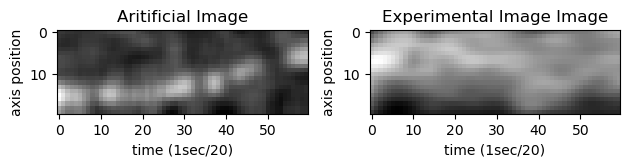

In [11]:
#Load the artificial, experimental kymographs
#This consumes a non-trivial amount of memory, so comment out when actually training the model

with open(art_json, 'r') as f:
  art_kymo = np.asarray(json.loads(f.read())["kymoset"])

with open(exp_json, 'r') as f:
  exp_kymo = np.asarray(json.loads(f.read()))

#Plot to ensure correct loading
plt.subplot(1,2,1)
plt.title('Aritificial Image')
plt.xlabel('time (1sec/20)')
plt.ylabel('axis position')
plt.imshow(art_kymo[0,:,:], cmap='gray', interpolation='nearest')

plt.subplot(1,2,2)
plt.title('Experimental Image Image')
plt.xlabel('time (1sec/20)')
plt.ylabel('axis position')
#note that the artificial indicies are position[0] while experimental are position[2]
plt.imshow(exp_kymo[:,:,0], cmap='gray', interpolation='nearest')

plt.tight_layout()
plt.show()

In [12]:
class ArtKymoDataset(Dataset):
    def __init__(self):
        #data loading
        with open(art_json, 'r') as f:
            kymos = np.asarray(json.loads(f.read())["kymoset"])

        self.x = torch.from_numpy(kymos)
        self.n_samples = kymos.shape[0]

    def __getitem__(self, index):
        return self.x[index,:,:]

    def __len__(self):
        return self.n_samples

In [13]:
class ExpKymoDataset(Dataset):
    def __init__(self):
        #data loading
        with open(exp_json, 'r') as f:
            kymos = np.asarray(json.loads(f.read()))

        self.x = torch.from_numpy(kymos)
        self.n_samples = kymos.shape[2]

    def __getitem__(self, index):
        return self.x[:,:,index]

    def __len__(self):
        return self.n_samples

In [14]:
#Dataloader test for arificial dataset

batch_size = 5
dataset = ArtKymoDataset()
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
print(ArtKymoDataset.__len__(dataset))

dataiter = iter(dataloader)
data = dataiter._next_data()

#display first batch!
print(len(data))

#training loop
num_epochs = 2
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/batch_size)

for epoch in range(num_epochs):
    for i, inputs in enumerate(dataloader):
        #forward, backward, update
        if (i+1) % 5 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}, inputs {inputs.shape}') #summary for debugging

300
5
epoch 1/2, step 5/60, inputs torch.Size([5, 20, 60])
epoch 1/2, step 10/60, inputs torch.Size([5, 20, 60])
epoch 1/2, step 15/60, inputs torch.Size([5, 20, 60])
epoch 1/2, step 20/60, inputs torch.Size([5, 20, 60])
epoch 1/2, step 25/60, inputs torch.Size([5, 20, 60])
epoch 1/2, step 30/60, inputs torch.Size([5, 20, 60])
epoch 1/2, step 35/60, inputs torch.Size([5, 20, 60])
epoch 1/2, step 40/60, inputs torch.Size([5, 20, 60])
epoch 1/2, step 45/60, inputs torch.Size([5, 20, 60])
epoch 1/2, step 50/60, inputs torch.Size([5, 20, 60])
epoch 1/2, step 55/60, inputs torch.Size([5, 20, 60])
epoch 1/2, step 60/60, inputs torch.Size([5, 20, 60])
epoch 2/2, step 5/60, inputs torch.Size([5, 20, 60])
epoch 2/2, step 10/60, inputs torch.Size([5, 20, 60])
epoch 2/2, step 15/60, inputs torch.Size([5, 20, 60])
epoch 2/2, step 20/60, inputs torch.Size([5, 20, 60])
epoch 2/2, step 25/60, inputs torch.Size([5, 20, 60])
epoch 2/2, step 30/60, inputs torch.Size([5, 20, 60])
epoch 2/2, step 35/60, i

In [15]:
#Dataloader test for experimental dataset

batch_size = 5
dataset = ExpKymoDataset()
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
print(ExpKymoDataset.__len__(dataset))

dataiter = iter(dataloader)
data = dataiter._next_data()

#display first batch!
print(len(data))

#training loop
num_epochs = 2
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/batch_size)

for epoch in range(num_epochs):
    for i, inputs in enumerate(dataloader):
        #forward, backward, update
        if (i+1) % 5 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}, inputs {inputs.shape}') #summary for debugging

112
5
epoch 1/2, step 5/23, inputs torch.Size([5, 20, 60])
epoch 1/2, step 10/23, inputs torch.Size([5, 20, 60])
epoch 1/2, step 15/23, inputs torch.Size([5, 20, 60])
epoch 1/2, step 20/23, inputs torch.Size([5, 20, 60])
epoch 2/2, step 5/23, inputs torch.Size([5, 20, 60])
epoch 2/2, step 10/23, inputs torch.Size([5, 20, 60])
epoch 2/2, step 15/23, inputs torch.Size([5, 20, 60])
epoch 2/2, step 20/23, inputs torch.Size([5, 20, 60])


In [23]:
### VAE setup ###

class VariationalEncoder(nn.Module):

    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc   #.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale  #.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z   


class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x


class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [24]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

vae.to(device)

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

In [25]:
### Training & testing functions ###

def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)


def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [26]:
def plot_vae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

In [27]:
### Load artificial/train data ###

batch_size = 5

train_dataset = ArtKymoDataset()

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

train_loader = DataLoader(dataset=train_data, batch_size=batch_size) #shuffle=True ?
valid_loader = DataLoader(dataset=val_data, batch_size=batch_size)

In [34]:
### Jamie trying to understand error here and in cell below ###

print(len(train_loader))

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

48


ValueError: too many values to unpack (expected 2)

In [29]:
num_epochs = 2

for epoch in range(num_epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   #plot_vae_outputs(vae.encoder,vae.decoder,n=10)

ValueError: too many values to unpack (expected 2)